In [1]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys
import gc

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K
tf.keras.mixed_precision.set_global_policy('mixed_float16')

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import mplhep as hep
    hep.style.use(hep.style.ROOT)
    print("Using MPL HEP for ROOT style formating")
except:
    print("Instal MPL HEP for style formating")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
#from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc
from functions import make_mse_loss


from data_preprocessing import prepare_data
#from model import build_AE, build_VAE, Sampling
from model import Sampling


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-12GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instal MPL HEP for style formating


In [2]:
####configuration####
#global input_qcd, input_bsm, events, load_pickle, input_pickle, output_pfile, \
        #output_model_h5, output_model_json, output_history, output_result, \
        #model_type, n_epochs

input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/QCD_preprocessed.h5"
input_bsm="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/BSM_preprocessed.h5"
events = 1000000
load_pickle=False
input_pickle="data.pickle"
output_pfile="data.pickle"
output_model_h5='model.h5'
output_model_json='model.json'
output_history='history.h5'
output_result='results.h5'
model_type='VAE'
batch_size= 1024
n_epochs = 150

In [3]:
def main(hyperparameters):
    
    latent_dim = hyperparameters[:,0]
    outer_layer_width = hyperparameters[:,1]
    inner_layer_width = hyperparameters[:,2]
    beta = hyperparameters[:,3]
    
    class VAE(Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
            self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
            self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="reconstruction_val_loss")
            self.kl_val_loss_tracker = keras.metrics.Mean(name="kl_val_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.total_val_loss_tracker,
                self.reconstruction_val_loss_tracker,
                self.kl_val_loss_tracker
            ]

        def train_step(self, data):
            print('Beta is ', beta)
            data_in, target = data
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data_in, training=True)
                reconstruction = self.decoder(z, training=True)
            
                reconstruction_loss = make_mse_loss(target, reconstruction) #one value
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(kl_loss, axis=-1)
                kl_loss = tf.cast(kl_loss, tf.float32)
                total_loss = (1-beta)*reconstruction_loss + beta*kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state((1-beta)*reconstruction_loss)
            self.kl_loss_tracker.update_state(beta*kl_loss)
        
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

        def test_step(self, data):
            #validation
            data_in, target = data
            z_mean, z_log_var, z = self.encoder(data_in)
            reconstruction = self.decoder(z)
        
            reconstruction_loss = make_mse_loss(target, reconstruction) 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)
            kl_loss = tf.cast(kl_loss, tf.float32)
            total_loss = (1-beta)*reconstruction_loss + beta*kl_loss
            self.total_val_loss_tracker.update_state(total_loss)
            self.reconstruction_val_loss_tracker.update_state((1-beta)*reconstruction_loss)
            self.kl_val_loss_tracker.update_state(beta*kl_loss)

            return {
                "loss": self.total_val_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_val_loss_tracker.result(),
                "kl_loss": self.kl_val_loss_tracker.result()
            }
    
        def save(self, path):
            pathlib.Path(path).mkdir(parents=True, exist_ok=True)
            print('saving model to {}'.format(path))
            self.encoder.save(os.path.join(path, 'encoder.h5'))
            self.decoder.save(os.path.join(path,'decoder.h5'))

        @classmethod
        def load(cls, path, custom_objects={}):
            ''' loading only for inference -> passing compile=False '''
            encoder = tf.keras.models.load_model(os.path.join(path,'encoder.h5'), custom_objects=custom_objects, compile=False)
            decoder = tf.keras.models.load_model(os.path.join(path,'decoder.h5'), custom_objects=custom_objects, compile=False)
            return encoder, decoder
    
        def build_AE(input_shape,latent_dim, outer_layer_width, inner_layer_width):
            inputArray = Input(shape=(input_shape))
            x = BatchNormalization()(inputArray)
            x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.3)(x)
            x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.3)(x)
            encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)
            # x = BatchNormalization()(x)
            # encoder = LeakyReLU(alpha=0.3)(x)
            #decoder
            x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.3)(x)
            x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.3)(x)
            decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)

            #create autoencoder
            autoencoder = Model(inputs = inputArray, outputs=decoder)
            autoencoder.summary()
            # ae = AE(autoencoder)
            # ae.compile(optimizer=keras.optimizers.Adam(lr=0.00001))

            return autoencoder
    
    def build_VAE(input_shape, latent_dim, outer_layer_width, inner_layer_width):
    
        #encoder
        inputArray = Input(shape=(input_shape))
        x = BatchNormalization()(inputArray)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        mu = Dense(latent_dim, name = 'latent_mu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        logvar = Dense(latent_dim, name = 'latent_logvar', kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)

        # Use reparameterization trick to ensure correct gradient
        z = Sampling()([mu, logvar])

        # Create encoder
        encoder = Model(inputArray, [mu, logvar, z], name='encoder')
        encoder.summary()

        #decoder
        d_input = Input(shape=(int(latent_dim),), name='decoder_input')
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(d_input)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        dec = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)

        # Create decoder 
        decoder = Model(d_input, dec, name='decoder')
        decoder.summary()
    
        # vae = VAE(encoder, decoder)
        # vae.compile(optimizer=keras.optimizers.Adam())

        return encoder,decoder
    
    if(load_pickle):
        if(input_pickle==''):
            print('Please provide input pickle files')
        with open(input_pickle, 'rb') as f:
            X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = pickle.load(f)
            bsm_labels=['VectorZPrimeToQQ__M50',
                  'VectorZPrimeToQQ__M100',
                  'VectorZPrimeToQQ__M200',
                  'VBF_HToInvisible_M125',
                  'VBF_HToInvisible_M125_private',
                  'ZprimeToZH_MZprime1000',
                  'ZprimeToZH_MZprime800',
                  'ZprimeToZH_MZprime600',
                  'GluGluToHHTo4B',
                  'HTo2LongLivedTo4mu_1000',
                  'HTo2LongLivedTo4mu_125_12',
                  'HTo2LongLivedTo4mu_125_25',
                  'HTo2LongLivedTo4mu_125_50',
                  'VBFHToTauTau',
                  'VBF_HH']
    else:
        if(input_qcd==''or input_bsm==''):
            print('Please provide input H5 files')
        X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_qcd, input_bsm, events, output_pfile,True)
        
    if(model_type=='AE'):
        autoencoder = build_AE(X_train_flatten.shape[-1], latent_dim, outer_layer_width, inner_layer_width)
        model = AE(autoencoder)
        model.compile(optimizer=keras.optimizers.Adam(lr=0.001))

        callbacks=[]
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
        callbacks.append(TerminateOnNaN())
        callbacks.append(NeptuneMonitor())
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

    elif(model_type=='VAE'):
        encoder, decoder = build_VAE(X_train_flatten.shape[-1], latent_dim, outer_layer_width, inner_layer_width)
        model = VAE(encoder, decoder)
        model.compile(optimizer=keras.optimizers.Adam())

        callbacks=[]
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
        callbacks.append(TerminateOnNaN())
        callbacks.append(NeptuneMonitor())
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

    history = model.fit(X_train_flatten, X_train_scaled,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=callbacks)

    del X_train_flatten, X_train_scaled


    gc.collect()
    
    if(output_model_h5!=''):
        if(model_type=='VAE'):
            model.save(os.path.join(os.getcwd(),output_model_h5.split('.')[0]))
        else:
            model_json = autoencoder.to_json()
            with open(output_model_json, 'w') as json_file:
                json_file.write(model_json)
            autoencoder.save_weights(output_model_h5)


    if(output_history!=''):
        with open(output_history, 'wb') as f:
            pickle.dump(history.history, f)
    
    #load model
    model_dir = output_model_h5.split('.')[0]
    if(model_type=='AE'):
        with open(model_dir+"/model.json", 'r') as jsonfile: config = jsonfile.read()
        ae = tf.keras.models.model_from_json(config)    
        ae.load_weights(model_dir+"/model.h5")
        ae.summary()
        model = AE(ae)
    elif(model_type=='VAE'):
        encoder, decoder = VAE.load(model_dir, custom_objects={'Sampling': Sampling})
        encoder.summary()
        decoder.summary()
        model = VAE(encoder, decoder)
    
    from end2end import get_results
    data_file = input_pickle
    outdir = output_model_h5.split('.')[0]
    if not load_pickle: data_file = output_pfile
    results = get_results(input_qcd,input_bsm,data_file,outdir,events,model_type,latent_dim)   
    
    for key in results.keys():
        results[key]['loss'] = results[key]['loss'][np.isfinite(results[key]['loss'])]
        results[key]['total_loss'] = results[key]['total_loss'][np.isfinite(results[key]['total_loss'])]
        results[key]['radius'] = results[key]['radius'][np.isfinite(results[key]['radius'])]

    signal_eff={}

    for key in results.keys():
        if key=='QCD': continue
        signal_eff[key]={}
        true_label = np.concatenate(( np.ones(results[key]['loss'].shape[0]), np.zeros(results['QCD']['loss'].shape[0]) ))
        pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        signal_eff[key]['MSE_loss']=tpr_loss[fpr_loss<0.000125][-1]

        auc_loss = auc(fpr_loss, tpr_loss)

    if(model_type=='VAE'):
        #plt.figure(figsize=(10,10))
        for key in results.keys():
            if key=='QCD': continue

            true_label = np.concatenate(( np.ones(results[key]['total_loss'].shape[0]), np.zeros(results['QCD']['total_loss'].shape[0]) ))
            pred_loss = np.concatenate(( results[key]['total_loss'], results['QCD']['total_loss'] ))
            fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
            signal_eff[key]['KL_loss']=tpr_loss[fpr_loss<0.000125][-1]

            auc_loss = auc(fpr_loss, tpr_loss)
  
        for key in results.keys():
            if key=='QCD': continue

            true_label = np.concatenate(( np.ones(results[key]['radius'].shape[0]), np.zeros(results['QCD']['radius'].shape[0]) ))
            pred_loss = np.concatenate(( results[key]['radius'], results['QCD']['radius'] ))
            fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
            signal_eff[key]['radius']=tpr_loss[fpr_loss<0.000125][-1]
        
        
            auc_loss = auc(fpr_loss, tpr_loss)
    
    signal_eff_pd = pd.DataFrame.from_dict(signal_eff).transpose()

    #return auc_loss
    return -(tpr_loss[fpr_loss<0.000125][-1])

In [4]:
%matplotlib inline  
import GPy
import GPyOpt
from numpy.random import seed

bounds = [{'name': 'latent_dim', 'type': 'discrete', 'domain':(3, 4, 5, 6, 7, 8)},
          {'name': 'outer_layer_width', 'type': 'discrete', 'domain':(16, 32, 64, 128)},
          {'name': 'inner_layer_width', 'type': 'discrete', 'domain':(16, 32, 64)},
          {'name': 'beta', 'type': 'continuous', 'domain':(0,1)}]

max_iter = 100
myProblem = GPyOpt.methods.BayesianOptimization(main, domain=bounds)
myProblem.run_optimization(max_iter)


*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data


2022-05-01 23:24:41.199489: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 23:24:42.776442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8921 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 32)           1856        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128         ['dense[0][0]']            

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 32)           1856        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128         ['dense[0][0]']            

Epoch 1/150
Beta is  [0.84117506]
Beta is  [0.84117506]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.4625 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 57)          228         ['input_2[0][0]']                
 rmalization)                                                                                     
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 57)          228         ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_10 (Dense)               (None, 16)           928         ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16)          64          ['dense_10[0][0]']         

Epoch 1/150
Beta is  [0.28492653]
Beta is  [0.28492653]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.8386 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 57)          228         ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 57)]         0           []                 

Epoch 10/150
390/391 [============================>.] - ETA: 0s - loss: 0.4367 - reconstruction_loss: 0.4360 - kl_loss: 0.0012
Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 14s 35ms/step - loss: 0.4367 - reconstruction_loss: 0.4360 - kl_loss: 0.0012 - val_loss: 0.4349 - val_reconstruction_loss: 0.4331 - val_kl_loss: 0.0018 - lr: 0.0010
Epoch 11/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4358 - reconstruction_loss: 0.4352 - kl_loss: 0.0014 - val_loss: 0.4340 - val_reconstruction_loss: 0.4326 - val_kl_loss: 0.0014 - lr: 1.0000e-04
Epoch 12/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4354 - reconstruction_loss: 0.4352 - kl_loss: 0.0012 - val_loss: 0.4342 - val_reconstruction_loss: 0.4329 - val_kl_loss: 0.0014 - lr: 1.0000e-04
Epoch 13/150
391/391 [==============================] - ETA: 0s - loss: 0.4346 - reconstruction_loss: 0.4351 - kl_loss: 0.0011
Epoch 0

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_20 (BatchN  (None, 57)          228         ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_20 (Dense)               (None, 64)           3712        ['batch_normalization_20[0][0]'] 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 64)          256         ['dense_20[0][0]']         

Epoch 1/150
Beta is  [0.62026182]
Beta is  [0.62026182]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 4ms/step - loss: inf - reconstruction_loss: 0.7985 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_25 (BatchN  (None, 57)          228         ['input_6[0][0]']                
 ormalization)                                                                                    
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_30 (BatchN  (None, 57)          228         ['input_7[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_30 (Dense)               (None, 16)           928         ['batch_normalization_30[0][0]'] 
                                                                                                  
 batch_normalization_31 (BatchN  (None, 16)          64          ['dense_30[0][0]']         

 leaky_re_lu_31 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_39 (Dense)            (None, 57)                969       
                                                                 
Total params: 1,817
Trainable params: 1,721
Non-trainable params: 96
_________________________________________________________________
Epoch 1/150
Beta is  [0.]
Beta is  [0.]
391/391 [==============================] - 4s 4ms/step - loss: nan - reconstruction_loss: 2.7788 - kl_loss: nan - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: nan - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 57)]         0           []                           

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_40 (BatchN  (None, 57)          228         ['input_9[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_40 (Dense)               (None, 16)           928         ['batch_normalization_40[0][0]'] 
                                                                                                  
 batch_normalization_41 (BatchN  (None, 16)          64          ['dense_40[0][0]']         

Epoch 1/150
Beta is  [0.47490837]
Beta is  [0.47490837]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.4654 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_45 (BatchN  (None, 57)          228         ['input_10[0][0]']               
 ormalization)                                                                                    
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_50 (BatchN  (None, 57)          228         ['input_11[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_50 (Dense)               (None, 16)           928         ['batch_normalization_50[0][0]'] 
                                                                                                  
 batch_normalization_51 (BatchN  (None, 16)          64          ['dense_50[0][0]']         

Epoch 1/150
Beta is  [0.48148072]
Beta is  [0.48148072]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.5952 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_55 (BatchN  (None, 57)          228         ['input_12[0][0]']               
 ormalization)                                                                                    
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_60 (BatchN  (None, 57)          228         ['input_13[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_60 (Dense)               (None, 16)           928         ['batch_normalization_60[0][0]'] 
                                                                                                  
 batch_normalization_61 (BatchN  (None, 16)          64          ['dense_60[0][0]']         

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_67 (Dense)            (None, 64)                576       
                                                                 
 batch_normalization_68 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_68 (Dense)            (None, 16)                1040      
                                                                 
 batch_normalization_69 (Bat  (None, 16)               64        
 chNormalization)                                          

Epoch 30/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6392 - reconstruction_loss: 0.6199 - kl_loss: 0.0187 - val_loss: 0.6357 - val_reconstruction_loss: 0.6162 - val_kl_loss: 0.0195 - lr: 1.0000e-04
Epoch 31/150
391/391 [==============================] - ETA: 0s - loss: 0.6388 - reconstruction_loss: 0.6202 - kl_loss: 0.0187
Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
391/391 [==============================] - 14s 35ms/step - loss: 0.6388 - reconstruction_loss: 0.6202 - kl_loss: 0.0187 - val_loss: 0.6358 - val_reconstruction_loss: 0.6166 - val_kl_loss: 0.0192 - lr: 1.0000e-04
Epoch 32/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6375 - reconstruction_loss: 0.6199 - kl_loss: 0.0188 - val_loss: 0.6362 - val_reconstruction_loss: 0.6167 - val_kl_loss: 0.0194 - lr: 1.0000e-05
Epoch 33/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6381 - reconstruction_loss: 0.6200 - kl_loss: 0.01

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_65 (BatchN  (None, 57)          228         ['input_14[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_65 (Dense)               (None, 16)           928         ['batch_normalization_65[0][0]'] 
                                                                                                  
 batch_normalization_66 (BatchN  (None, 16)          64          ['dense_65[0][0]']         

Epoch 1/150
Beta is  [0.48686935]
Beta is  [0.48686935]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.4115 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_70 (BatchN  (None, 57)          228         ['input_15[0][0]']               
 ormalization)                                                                                    
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_75 (BatchN  (None, 57)          228         ['input_16[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_75 (Dense)               (None, 16)           928         ['batch_normalization_75[0][0]'] 
                                                                                                  
 batch_normalization_76 (BatchN  (None, 16)          64          ['dense_75[0][0]']         

Epoch 1/150
Beta is  [0.47886059]
Beta is  [0.47886059]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.6084 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_80 (BatchN  (None, 57)          228         ['input_17[0][0]']               
 ormalization)                                                                                    
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_85 (BatchN  (None, 57)          228         ['input_18[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_85 (Dense)               (None, 16)           928         ['batch_normalization_85[0][0]'] 
                                                                                                  
 batch_normalization_86 (BatchN  (None, 16)          64          ['dense_85[0][0]']         

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_92 (Dense)            (None, 64)                576       
                                                                 
 batch_normalization_93 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_93 (Dense)            (None, 16)                1040      
                                                                 
 batch_normalization_94 (Bat  (None, 16)               64        
 chNormalization)                                          

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_95 (BatchN  (None, 57)          228         ['input_20[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_95 (Dense)               (None, 16)           928         ['batch_normalization_95[0][0]'] 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 16)          64          ['dense_95[0][0]']         

Epoch 1/150
Beta is  [0.30826171]
Beta is  [0.30826171]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 2.1039 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_100 (Batch  (None, 57)          228         ['input_21[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_105 (Batch  (None, 57)          228         ['input_22[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_105 (Dense)              (None, 16)           928         ['batch_normalization_105[0][0]']
                                                                                                  
 batch_normalization_106 (Batch  (None, 16)          64          ['dense_105[0][0]']        

Epoch 1/150
Beta is  [0.60729753]
Beta is  [0.60729753]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.8618 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_110 (Batch  (None, 57)          228         ['input_23[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_115 (Batch  (None, 57)          228         ['input_24[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_115 (Dense)              (None, 16)           928         ['batch_normalization_115[0][0]']
                                                                                                  
 batch_normalization_116 (Batch  (None, 16)          64          ['dense_115[0][0]']        

Epoch 1/150
Beta is  [0.692367]
Beta is  [0.692367]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.5821 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_120 (Batch  (None, 57)          228         ['input_25[0][0]']               
 Normalization)                                                                                   
                                         

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_125 (Batch  (None, 57)          228         ['input_26[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_125 (Dense)              (None, 16)           928         ['batch_normalization_125[0][0]']
                                                                                                  
 batch_normalization_126 (Batch  (None, 16)          64          ['dense_125[0][0]']        

Epoch 1/150
Beta is  [0.44773045]
Beta is  [0.44773045]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.1952 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_130 (Batch  (None, 57)          228         ['input_27[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_135 (Batch  (None, 57)          228         ['input_28[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_135 (Dense)              (None, 16)           928         ['batch_normalization_135[0][0]']
                                                                                                  
 batch_normalization_136 (Batch  (None, 16)          64          ['dense_135[0][0]']        

Epoch 1/150
Beta is  [0.6924131]
Beta is  [0.6924131]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.8838 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_140 (Batch  (None, 57)          228         ['input_29[0][0]']               
 Normalization)                                                                                   
                                                                                   

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_145 (Batch  (None, 57)          228         ['input_30[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_145 (Dense)              (None, 16)           928         ['batch_normalization_145[0][0]']
                                                                                                  
 batch_normalization_146 (Batch  (None, 16)          64          ['dense_145[0][0]']        

Epoch 1/150
Beta is  [0.32369951]
Beta is  [0.32369951]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 2.0130 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_150 (Batch  (None, 57)          228         ['input_31[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_155 (Batch  (None, 57)          228         ['input_32[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_155 (Dense)              (None, 16)           928         ['batch_normalization_155[0][0]']
                                                                                                  
 batch_normalization_156 (Batch  (None, 16)          64          ['dense_155[0][0]']        

Epoch 1/150
Beta is  [0.68991581]
Beta is  [0.68991581]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.8956 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_160 (Batch  (None, 57)          228         ['input_33[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_165 (Batch  (None, 57)          228         ['input_34[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_165 (Dense)              (None, 16)           928         ['batch_normalization_165[0][0]']
                                                                                                  
 batch_normalization_166 (Batch  (None, 16)          64          ['dense_165[0][0]']        

Epoch 1/150
Beta is  [0.46005559]
Beta is  [0.46005559]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.0287 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_170 (Batch  (None, 57)          228         ['input_35[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_175 (Batch  (None, 57)          228         ['input_36[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_175 (Dense)              (None, 16)           928         ['batch_normalization_175[0][0]']
                                                                                                  
 batch_normalization_176 (Batch  (None, 16)          64          ['dense_175[0][0]']        

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_182 (Dense)           (None, 32)                288       
                                                                 
 batch_normalization_183 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_146 (LeakyReLU)  (None, 32)               0         
                                                                 
 dense_183 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_184 (Ba  (None, 16)               64        
 tchNormalization)                                         

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_185 (Batch  (None, 57)          228         ['input_38[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_185 (Dense)              (None, 16)           928         ['batch_normalization_185[0][0]']
                                                                                                  
 batch_normalization_186 (Batch  (None, 16)          64          ['dense_185[0][0]']        

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_192 (Dense)           (None, 32)                288       
                                                                 
 batch_normalization_193 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_154 (LeakyReLU)  (None, 32)               0         
                                                                 
 dense_193 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_194 (Ba  (None, 16)               64        
 tchNormalization)                                         

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_195 (Batch  (None, 57)          228         ['input_40[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_195 (Dense)              (None, 16)           928         ['batch_normalization_195[0][0]']
                                                                                                  
 batch_normalization_196 (Batch  (None, 16)          64          ['dense_195[0][0]']        

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_202 (Dense)           (None, 64)                576       
                                                                 
 batch_normalization_203 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_162 (LeakyReLU)  (None, 64)               0         
                                                                 
 dense_203 (Dense)           (None, 16)                1040      
                                                                 
 batch_normalization_204 (Ba  (None, 16)               64        
 tchNormalization)                                         

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_205 (Batch  (None, 57)          228         ['input_42[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_205 (Dense)              (None, 16)           928         ['batch_normalization_205[0][0]']
                                                                                                  
 batch_normalization_206 (Batch  (None, 16)          64          ['dense_205[0][0]']        

Epoch 1/150
Beta is  [0.44129948]
Beta is  [0.44129948]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.5308 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_210 (Batch  (None, 57)          228         ['input_43[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_215 (Batch  (None, 57)          228         ['input_44[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_215 (Dense)              (None, 16)           928         ['batch_normalization_215[0][0]']
                                                                                                  
 batch_normalization_216 (Batch  (None, 16)          64          ['dense_215[0][0]']        

Epoch 1/150
Beta is  [0.49774976]
Beta is  [0.49774976]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.0242 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_220 (Batch  (None, 57)          228         ['input_45[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 57)]         0           []                 

Epoch 00045: early stopping
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_225 (Batch  (None, 57)          228         ['input_46[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_225 (Dense)              (None, 16)           928         ['batch_normalization_225[0][0]']
                                                                                                  
 ba

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_230 (Batch  (None, 57)          228         ['input_47[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_230 (Dense)              (None, 16)           928         ['batch_normalization_230[0][0]']
                                                                                                  
 batch_normalization_231 (Batch  (None, 16)          64          ['dense_230[0][0]']        

Epoch 1/150
Beta is  [0.43549062]
Beta is  [0.43549062]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.7302 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_235 (Batch  (None, 57)          228         ['input_48[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_240 (Batch  (None, 57)          228         ['input_49[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_240 (Dense)              (None, 16)           928         ['batch_normalization_240[0][0]']
                                                                                                  
 batch_normalization_241 (Batch  (None, 16)          64          ['dense_240[0][0]']        

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_247 (Dense)           (None, 32)                288       
                                                                 
 batch_normalization_248 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_198 (LeakyReLU)  (None, 32)               0         
                                                                 
 dense_248 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_249 (Ba  (None, 16)               64        
 tchNormalization)                                         

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 57)]         0           []                 

Epoch 00010: early stopping
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_250 (Batch  (None, 57)          228         ['input_51[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_250 (Dense)              (None, 16)           928         ['batch_normalization_250[0][0]']
                                                                                                  
 ba

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_255 (Batch  (None, 57)          228         ['input_52[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_255 (Dense)              (None, 32)           1856        ['batch_normalization_255[0][0]']
                                                                                                  
 batch_normalization_256 (Batch  (None, 32)          128         ['dense_255[0][0]']        

Epoch 1/150
Beta is  [0.43974469]
Beta is  [0.43974469]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.6491 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_260 (Batch  (None, 57)          228         ['input_53[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_265 (Batch  (None, 57)          228         ['input_54[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_265 (Dense)              (None, 32)           1856        ['batch_normalization_265[0][0]']
                                                                                                  
 batch_normalization_266 (Batch  (None, 32)          128         ['dense_265[0][0]']        

Epoch 1/150
Beta is  [0.49038291]
Beta is  [0.49038291]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.4858 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_270 (Batch  (None, 57)          228         ['input_55[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_275 (Batch  (None, 57)          228         ['input_56[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_275 (Dense)              (None, 16)           928         ['batch_normalization_275[0][0]']
                                                                                                  
 batch_normalization_276 (Batch  (None, 16)          64          ['dense_275[0][0]']        

Epoch 1/150
Beta is  [0.43934402]
Beta is  [0.43934402]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.6493 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_280 (Batch  (None, 57)          228         ['input_57[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_285 (Batch  (None, 57)          228         ['input_58[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_285 (Dense)              (None, 16)           928         ['batch_normalization_285[0][0]']
                                                                                                  
 batch_normalization_286 (Batch  (None, 16)          64          ['dense_285[0][0]']        

Epoch 1/150
Beta is  [0.69129464]
Beta is  [0.69129464]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.7378 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_290 (Batch  (None, 57)          228         ['input_59[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_295 (Batch  (None, 57)          228         ['input_60[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_295 (Dense)              (None, 16)           928         ['batch_normalization_295[0][0]']
                                                                                                  
 batch_normalization_296 (Batch  (None, 16)          64          ['dense_295[0][0]']        

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_302 (Dense)           (None, 32)                288       
                                                                 
 batch_normalization_303 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_242 (LeakyReLU)  (None, 32)               0         
                                                                 
 dense_303 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_304 (Ba  (None, 16)               64        
 tchNormalization)                                         

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_305 (Batch  (None, 57)          228         ['input_62[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_305 (Dense)              (None, 16)           928         ['batch_normalization_305[0][0]']
                                                                                                  
 batch_normalization_306 (Batch  (None, 16)          64          ['dense_305[0][0]']        

Epoch 1/150
Beta is  [0.43627018]
Beta is  [0.43627018]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.8261 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_63 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_310 (Batch  (None, 57)          228         ['input_63[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_315 (Batch  (None, 57)          228         ['input_64[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_315 (Dense)              (None, 16)           928         ['batch_normalization_315[0][0]']
                                                                                                  
 batch_normalization_316 (Batch  (None, 16)          64          ['dense_315[0][0]']        

Epoch 1/150
Beta is  [0.49628772]
Beta is  [0.49628772]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.4244 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_320 (Batch  (None, 57)          228         ['input_65[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_325 (Batch  (None, 57)          228         ['input_66[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_325 (Dense)              (None, 16)           928         ['batch_normalization_325[0][0]']
                                                                                                  
 batch_normalization_326 (Batch  (None, 16)          64          ['dense_325[0][0]']        

Epoch 1/150
Beta is  [0.32101169]
Beta is  [0.32101169]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 2.0841 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_330 (Batch  (None, 57)          228         ['input_67[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_68 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_68 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_335 (Batch  (None, 57)          228         ['input_68[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_335 (Dense)              (None, 16)           928         ['batch_normalization_335[0][0]']
                                                                                                  
 batch_normalization_336 (Batch  (None, 16)          64          ['dense_335[0][0]']        

Epoch 1/150
Beta is  [0.60814742]
Beta is  [0.60814742]
391/391 [==============================] - 4s 4ms/step - loss: inf - reconstruction_loss: 1.1894 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_340 (Batch  (None, 57)          228         ['input_69[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 57)]         0           []                 

Epoch 00010: early stopping
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_345 (Batch  (None, 57)          228         ['input_70[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_345 (Dense)              (None, 16)           928         ['batch_normalization_345[0][0]']
                                                                                                  
 ba

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_71 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_71 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_350 (Batch  (None, 57)          228         ['input_71[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_350 (Dense)              (None, 16)           928         ['batch_normalization_350[0][0]']
                                                                                                  
 batch_normalization_351 (Batch  (None, 16)          64          ['dense_350[0][0]']        

Epoch 1/150
Beta is  [0.69420174]
Beta is  [0.69420174]
391/391 [==============================] - 17s 36ms/step - loss: 1.1109 - reconstruction_loss: 0.5520 - kl_loss: 0.2046 - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
Epoch 2/150
391/391 [==============================] - ETA: 0s - loss: 0.4944 - reconstruction_loss: 0.4438 - kl_loss: 0.0376
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 14s 36ms/step - loss: 0.4944 - reconstruction_loss: 0.4438 - kl_loss: 0.0376 - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
Epoch 3/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4634 - reconstruction_loss: 0.4403 - kl_loss: 0.0233 - val_loss: inf - val_reconstruction_loss: 1.5620 - val_kl_loss: inf - lr: 1.0000e-04
Epoch 4/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4608 - reconstruction_loss: 0.4399 - kl_lo

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_360 (Batch  (None, 57)          228         ['input_73[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_360 (Dense)              (None, 16)           928         ['batch_normalization_360[0][0]']
                                                                                                  
 batch_normalization_361 (Batch  (None, 16)          64          ['dense_360[0][0]']        

Epoch 1/150
Beta is  [0.47700984]
Beta is  [0.47700984]
391/391 [==============================] - 17s 36ms/step - loss: 1.3461 - reconstruction_loss: 0.8896 - kl_loss: 0.1151 - val_loss: 0.7863 - val_reconstruction_loss: 0.7511 - val_kl_loss: 0.0353 - lr: 0.0010
Epoch 2/150
391/391 [==============================] - 14s 35ms/step - loss: 0.7745 - reconstruction_loss: 0.7431 - kl_loss: 0.0274 - val_loss: 0.7516 - val_reconstruction_loss: 0.7271 - val_kl_loss: 0.0246 - lr: 0.0010
Epoch 3/150
391/391 [==============================] - 14s 35ms/step - loss: 0.7529 - reconstruction_loss: 0.7281 - kl_loss: 0.0232 - val_loss: 0.7406 - val_reconstruction_loss: 0.7185 - val_kl_loss: 0.0222 - lr: 0.0010
Epoch 4/150
391/391 [==============================] - 14s 36ms/step - loss: 0.7464 - reconstruction_loss: 0.7209 - kl_loss: 0.0221 - val_loss: 0.7342 - val_reconstruction_loss: 0.7126 - val_kl_loss: 0.0217 - lr: 0.0010
Epoch 5/150
391/391 [==============================] - 14s 36ms/step - loss:

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_370 (Batch  (None, 57)          228         ['input_75[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_370 (Dense)              (None, 16)           928         ['batch_normalization_370[0][0]']
                                                                                                  
 batch_normalization_371 (Batch  (None, 16)          64          ['dense_370[0][0]']        

Epoch 1/150
Beta is  [0.44598911]
Beta is  [0.44598911]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.9932 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_76 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_375 (Batch  (None, 57)          228         ['input_76[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_380 (Batch  (None, 57)          228         ['input_77[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_380 (Dense)              (None, 16)           928         ['batch_normalization_380[0][0]']
                                                                                                  
 batch_normalization_381 (Batch  (None, 16)          64          ['dense_380[0][0]']        

Epoch 1/150
Beta is  [0.44598252]
Beta is  [0.44598252]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.5083 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_78 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_385 (Batch  (None, 57)          228         ['input_78[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_79 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_79 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_390 (Batch  (None, 57)          228         ['input_79[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_390 (Dense)              (None, 16)           928         ['batch_normalization_390[0][0]']
                                                                                                  
 batch_normalization_391 (Batch  (None, 16)          64          ['dense_390[0][0]']        

Epoch 1/150
Beta is  [0.44603139]
Beta is  [0.44603139]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.1902 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_395 (Batch  (None, 57)          228         ['input_80[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_400 (Batch  (None, 57)          228         ['input_81[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_400 (Dense)              (None, 16)           928         ['batch_normalization_400[0][0]']
                                                                                                  
 batch_normalization_401 (Batch  (None, 16)          64          ['dense_400[0][0]']        

Epoch 1/150
Beta is  [0.44610575]
Beta is  [0.44610575]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.6389 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_405 (Batch  (None, 57)          228         ['input_82[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_83 (InputLayer)          [(None, 57)]         0           []                 

391/391 [==============================] - 14s 37ms/step - loss: 0.7517 - reconstruction_loss: 0.6986 - kl_loss: 0.0531 - val_loss: 0.7514 - val_reconstruction_loss: 0.6981 - val_kl_loss: 0.0532 - lr: 1.0000e-06
Epoch 47/150
391/391 [==============================] - 14s 37ms/step - loss: 0.7513 - reconstruction_loss: 0.6984 - kl_loss: 0.0531 - val_loss: 0.7515 - val_reconstruction_loss: 0.6982 - val_kl_loss: 0.0533 - lr: 1.0000e-06
Epoch 48/150
391/391 [==============================] - 14s 37ms/step - loss: 0.7517 - reconstruction_loss: 0.6986 - kl_loss: 0.0531 - val_loss: 0.7521 - val_reconstruction_loss: 0.6987 - val_kl_loss: 0.0534 - lr: 1.0000e-06
Epoch 00048: early stopping
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_83 (InputLayer)          [(

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_84 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_84 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_415 (Batch  (None, 57)          228         ['input_84[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_415 (Dense)              (None, 16)           928         ['batch_normalization_415[0][0]']
                                                                                                  
 batch_normalization_416 (Batch  (None, 16)          64          ['dense_415[0][0]']        

Epoch 1/150
Beta is  [0.44578788]
Beta is  [0.44578788]
391/391 [==============================] - 17s 36ms/step - loss: 1.5215 - reconstruction_loss: 0.9954 - kl_loss: 0.1363 - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
Epoch 2/150
391/391 [==============================] - ETA: 0s - loss: 0.8265 - reconstruction_loss: 0.7811 - kl_loss: 0.0346
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [==============================] - 14s 35ms/step - loss: 0.8264 - reconstruction_loss: 0.7811 - kl_loss: 0.0346 - val_loss: inf - val_reconstruction_loss: 0.8566 - val_kl_loss: inf - lr: 0.0010
Epoch 3/150
391/391 [==============================] - 14s 35ms/step - loss: 0.8027 - reconstruction_loss: 0.7714 - kl_loss: 0.0293 - val_loss: inf - val_reconstruction_loss: 5.1041 - val_kl_loss: inf - lr: 1.0000e-04
Epoch 4/150
391/391 [==============================] - 13s 35ms/step - loss: 0.7961 - reconstruction_loss: 0.7701 - kl

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_86 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_86 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_425 (Batch  (None, 57)          228         ['input_86[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_425 (Dense)              (None, 16)           928         ['batch_normalization_425[0][0]']
                                                                                                  
 batch_normalization_426 (Batch  (None, 16)          64          ['dense_425[0][0]']        

 batch_normalization_434 (Ba  (None, 16)               64        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_347 (LeakyReLU)  (None, 16)               0         
                                                                 
 dense_434 (Dense)           (None, 57)                969       
                                                                 
Total params: 1,977
Trainable params: 1,881
Non-trainable params: 96
_________________________________________________________________
Epoch 1/150
Beta is  [0.44586785]
Beta is  [0.44586785]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.7490 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
______________________________________________________________________________

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_88 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_88 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_435 (Batch  (None, 57)          228         ['input_88[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_435 (Dense)              (None, 16)           928         ['batch_normalization_435[0][0]']
                                                                                                  
 batch_normalization_436 (Batch  (None, 16)          64          ['dense_435[0][0]']        

Epoch 1/150
Beta is  [0.69015871]
Beta is  [0.69015871]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 0.8439 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_89 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_440 (Batch  (None, 57)          228         ['input_89[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_90 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_90 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_445 (Batch  (None, 57)          228         ['input_90[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_445 (Dense)              (None, 16)           928         ['batch_normalization_445[0][0]']
                                                                                                  
 batch_normalization_446 (Batch  (None, 16)          64          ['dense_445[0][0]']        

Epoch 1/150
Beta is  [0.44588122]
Beta is  [0.44588122]
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.5897 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_91 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_450 (Batch  (None, 57)          228         ['input_91[0][0]']               
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_92 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_92 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_455 (Batch  (None, 57)          228         ['input_92[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_455 (Dense)              (None, 16)           928         ['batch_normalization_455[0][0]']
                                                                                                  
 batch_normalization_456 (Batch  (None, 16)          64          ['dense_455[0][0]']        

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_462 (Dense)           (None, 32)                288       
                                                                 
 batch_normalization_463 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_370 (LeakyReLU)  (None, 32)               0         
                                                                 
 dense_463 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_464 (Ba  (None, 16)               64        
 tchNormalization)                                         

Epoch 27/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4392 - reconstruction_loss: 0.4383 - kl_loss: 0.0018 - val_loss: 0.4407 - val_reconstruction_loss: 0.4379 - val_kl_loss: 0.0028 - lr: 1.0000e-06
Epoch 28/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4391 - reconstruction_loss: 0.4383 - kl_loss: 0.0018 - val_loss: 0.4406 - val_reconstruction_loss: 0.4380 - val_kl_loss: 0.0027 - lr: 1.0000e-06
Epoch 29/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4424 - reconstruction_loss: 0.4383 - kl_loss: 0.0018 - val_loss: 0.4406 - val_reconstruction_loss: 0.4379 - val_kl_loss: 0.0028 - lr: 1.0000e-06
Epoch 30/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4405 - reconstruction_loss: 0.4382 - kl_loss: 0.0018 - val_loss: 0.4405 - val_reconstruction_loss: 0.4377 - val_kl_loss: 0.0029 - lr: 1.0000e-06
Epoch 31/150
391/391 [==============================] - 14s 35ms/step - loss: 0.4381 - reconstructio

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_93 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_460 (Batch  (None, 57)          228         ['input_93[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_460 (Dense)              (None, 16)           928         ['batch_normalization_460[0][0]']
                                                                                                  
 batch_normalization_461 (Batch  (None, 16)          64          ['dense_460[0][0]']        

Epoch 1/150
Beta is  [0.4691989]
Beta is  [0.4691989]
391/391 [==============================] - 4s 4ms/step - loss: inf - reconstruction_loss: 1.6320 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_465 (Batch  (None, 57)          228         ['input_94[0][0]']               
 Normalization)                                                                                   
                                                                                   

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_95 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_95 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_470 (Batch  (None, 57)          228         ['input_95[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_470 (Dense)              (None, 16)           928         ['batch_normalization_470[0][0]']
                                                                                                  
 batch_normalization_471 (Batch  (None, 16)          64          ['dense_470[0][0]']        

Epoch 1/150
Beta is  [0.56760541]
Beta is  [0.56760541]
391/391 [==============================] - 17s 37ms/step - loss: 1.0941 - reconstruction_loss: 0.7340 - kl_loss: 0.0867 - val_loss: 0.6598 - val_reconstruction_loss: 0.6363 - val_kl_loss: 0.0235 - lr: 0.0010
Epoch 2/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6361 - reconstruction_loss: 0.6151 - kl_loss: 0.0166 - val_loss: 0.6292 - val_reconstruction_loss: 0.6159 - val_kl_loss: 0.0133 - lr: 0.0010
Epoch 3/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6257 - reconstruction_loss: 0.6102 - kl_loss: 0.0106 - val_loss: 0.6208 - val_reconstruction_loss: 0.6094 - val_kl_loss: 0.0115 - lr: 0.0010
Epoch 4/150
391/391 [==============================] - 14s 36ms/step - loss: 0.6179 - reconstruction_loss: 0.6083 - kl_loss: 0.0089 - val_loss: 0.6177 - val_reconstruction_loss: 0.6075 - val_kl_loss: 0.0103 - lr: 0.0010
Epoch 5/150
391/391 [==============================] - 14s 35ms/step - loss:

391/391 [==============================] - 12s 32ms/step - loss: 0.6105 - reconstruction_loss: 0.6027 - kl_loss: 0.0084 - val_loss: 0.6137 - val_reconstruction_loss: 0.6047 - val_kl_loss: 0.0091 - lr: 1.0000e-06
Epoch 35/150
391/391 [==============================] - 6s 15ms/step - loss: 0.6100 - reconstruction_loss: 0.6028 - kl_loss: 0.0084 - val_loss: 0.6139 - val_reconstruction_loss: 0.6051 - val_kl_loss: 0.0089 - lr: 1.0000e-06
Epoch 36/150
391/391 [==============================] - 13s 34ms/step - loss: 0.6093 - reconstruction_loss: 0.6029 - kl_loss: 0.0084 - val_loss: 0.6144 - val_reconstruction_loss: 0.6057 - val_kl_loss: 0.0087 - lr: 1.0000e-06
Epoch 37/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6107 - reconstruction_loss: 0.6029 - kl_loss: 0.0084 - val_loss: 0.6144 - val_reconstruction_loss: 0.6056 - val_kl_loss: 0.0088 - lr: 1.0000e-06
Epoch 38/150
391/391 [==============================] - 14s 35ms/step - loss: 0.6144 - reconstruction_loss: 0.6028

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_96 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_475 (Batch  (None, 57)          228         ['input_96[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_475 (Dense)              (None, 16)           928         ['batch_normalization_475[0][0]']
                                                                                                  
 batch_normalization_476 (Batch  (None, 16)          64          ['dense_475[0][0]']        

Epoch 1/150
Beta is  [0.25755214]
Beta is  [0.25755214]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.7659 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_97 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_480 (Batch  (None, 57)          228         ['input_97[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_98 (InputLayer)          [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_98 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_485 (Batch  (None, 57)          228         ['input_98[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_485 (Dense)              (None, 16)           928         ['batch_normalization_485[0][0]']
                                                                                                  
 batch_normalization_486 (Batch  (None, 16)          64          ['dense_485[0][0]']        

Epoch 1/150
Beta is  [0.39984523]
Beta is  [0.39984523]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 5s 5ms/step - loss: inf - reconstruction_loss: 1.2939 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_99 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_490 (Batch  (None, 57)          228         ['input_99[0][0]']               
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_100 (InputLayer)         [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_100 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_495 (Batch  (None, 57)          228         ['input_100[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dense_495 (Dense)              (None, 16)           928         ['batch_normalization_495[0][0]']
                                                                                                  
 batch_normalization_496 (Batch  (None, 16)          64          ['dense_495[0][0]']        

Epoch 1/150
Beta is  [0.27720669]
Beta is  [0.27720669]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.9791 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_101 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_500 (Batch  (None, 57)          228         ['input_101[0][0]']              
 Normalization)                                                                                   
                                     

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_102 (InputLayer)         [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_102 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_505 (Batch  (None, 57)          228         ['input_102[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dense_505 (Dense)              (None, 16)           928         ['batch_normalization_505[0][0]']
                                                                                                  
 batch_normalization_506 (Batch  (None, 16)          64          ['dense_505[0][0]']        

Epoch 1/150
Beta is  [0.30753829]
Beta is  [0.30753829]
391/391 [==============================] - 4s 4ms/step - loss: inf - reconstruction_loss: 2.3423 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_103 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_510 (Batch  (None, 57)          228         ['input_103[0][0]']              
 Normalization)                                                                                   
                                                                                 

*** OutputFile Created
*** Reading QCD
QCD: (1000000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_104 (InputLayer)         [(None, 57)]         0           []                 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_104 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_515 (Batch  (None, 57)          228         ['input_104[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dense_515 (Dense)              (None, 16)           928         ['batch_normalization_515[0][0]']
                                                                                                  
 batch_normalization_516 (Batch  (None, 16)          64          ['dense_515[0][0]']        

Epoch 1/150
Beta is  [0.2312555]
Beta is  [0.2312555]
Batch 0: Invalid loss, terminating training
391/391 [==============================] - 4s 3ms/step - loss: inf - reconstruction_loss: 1.5517 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_105 (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_520 (Batch  (None, 57)          228         ['input_105[0][0]']              
 Normalization)                                                                                   
                                       

*** OutputFile Created


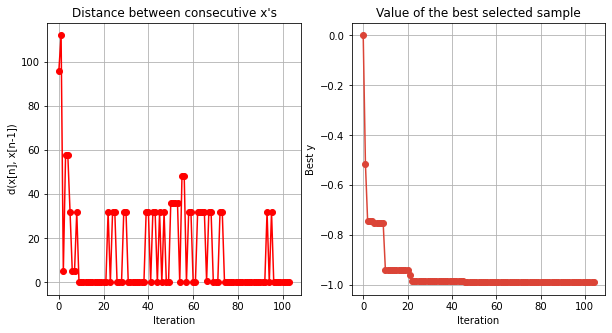

Writing evaluation results... 
     latent_dim  outer_layer_width  inner_layer_width      beta  efficiency
0           3.0               32.0               64.0  0.266643     0.00008
1           4.0              128.0               64.0  0.841175     0.51408
2           8.0               16.0               64.0  0.325322     0.74484
3           3.0               16.0               64.0  0.284927     0.30786
4           3.0               64.0               32.0  0.693627     0.00006
5           8.0               16.0               64.0  0.620262     0.75102
6           8.0               16.0               32.0  0.882036     0.67602
7           3.0               16.0               32.0  0.000000     0.39872
8           8.0               16.0               32.0  1.000000     0.08370
9           8.0               16.0               64.0  0.474908     0.65730
10          8.0               16.0               64.0  0.476619     0.93764
11          8.0               16.0               64.0  0.

In [9]:
# evaluate results of optimization
pd.set_option("display.max_rows", None, "display.max_columns", None)

myProblem.plot_convergence()
print('Writing evaluation results... ')
param1 = myProblem.get_evaluations()[0][:,0].flatten()
param2 = myProblem.get_evaluations()[0][:,1].flatten()
param3 = myProblem.get_evaluations()[0][:,2].flatten()
param4 = myProblem.get_evaluations()[0][:,3].flatten()
out = -1*myProblem.get_evaluations()[1][:].flatten()
opt_results = {'latent_dim': param1,
               'outer_layer_width': param2,
               'inner_layer_width': param3,
               'beta': param4,
               'efficiency': out}

evals = pd.DataFrame(opt_results)
print(evals)

print('The value of (latent_dim, outer_layer width, inner_layer_width, beta) that maximizes efficiency is: \n'+str(myProblem.x_opt))
print('The the max efficiency found is: '+str(-1*myProblem.fx_opt))